# 2. Building a machine learning pipeline

## Overview 
Having explored the data and defined the problem, we are ready to build an initial pipeline, with choices informed by our data exploration.

### Prerequisites

* Same as notebook 1 in this tutorial series, plus successful completion of notebook 1

### Learning Outcomes 
* Understand the fundamental steps in a machine learning pipeline
* Understand key terminology in describing the machine learning pipeline
* Initial understanding of how to choose appropriate components for each stage in the pipeline.

### Best Practices & Values

Link to Data Theme
Link to ethics Theme
link to ML lifecycle theme

## Tutorial - Key Elements of a Machine Learning Pipeline

Using a series of data science and machine learning and algorithms to go from input data to a series of predictions is usually referred to as a pipeline.  In this noteboook we will be exploring the key components of such a pipeline in constructing and training a machine learning algorithm with some input data.

In this notebook we will look at 2 pipeline, one for a **supervised** **classification** problem, and the other for an **unsupervised** clustering problem.

The steps we willl go through are as follows:
* *Data Loading & Cleaning* - Start by loading the data, and filtering out any data considered to be unsuitable training and evaluation of machine learning algorithms. Selection of appropriate data is an important way in which domain expertise in vital in getting good results.
* *Feauture Engineering* - The first step is to prepare the data for presenting to the algorithm. Different ways of presenting the data will emphasise different features, and choosing the right features is important for getting good results. Knowledge of what features represent based on domain knowledge is again very important.
* *Train/test Split* - Before we train the algorithm, we need to split into *train* and *test* sets. This is to ensure out algorithm doesn't *overfit*, learning irrelevant details that are not representative of the whole space of possible data, but rather that in generalises well.
* *Data Preparation* - The machine learning algorithm only sees numbers as numbers, with no inherent understnading oif meaning or context. We need to ensure different features are scaled to be comparable, otherwise big numbers will be treated as more important by the algorithm, irrespective of what those numbers mean. Value are typically scaled to a range of `[0,1]` or, assuming a gaussian distribution, to have `mean=0` and `std_dev=1`.
* *Algorithm Setup* - Here we select the particular algorithm e,.g. neural network, k-means clustering, and specify the *hyperparameters*. It is important to distinguish between *parameters* and *hyperparameters*. 
  * Parameters are the values that calculated by the training process. 
  * Hyperparameters are values specified in algorithm setup, which are not altered by training. These need to be fine-tuned using an additional outer training loop called hyperparameter tuning.
* *Algorithm Training* - Execute the algorithm to calculate the best parameters for the chosen ML algorithm to fit the supplied training data
* *Inference* - Once we have an algorithm, we use it to produce predictions, for both the train and test sets.
* *Evaluation* - We then compare the predictions of the trained algorithms to expected results. For supervised learning, this will be supplied target values. For unsupervised learning, we will expplore the results and their usefulness much like in exploratory data analysis.
* *Model Storage* - Model training can be an expensive process that we don't want to perform too often, and. once we have a model that performs well we save its state so it can be reloaded and used subsequently for inference on later problems.


### Key Terms

* supervised learning
* unsupervised learning
* regression
* classification
* metric
* parameter
* hyperparameter
* feature engineering
* training set
* validation set
* test set
* inference


## Problem 1: Supervised Classification - Falkland Islands Rotor Prediction

In [107]:
import warnings
warnings.filterwarnings('ignore')

In [21]:
import pathlib
import datetime
import os
import functools
import math

In [4]:
import matplotlib
%matplotlib inline

In [92]:
import numpy
import pandas

In [6]:
import iris
import iris.quickplot
import iris.coord_categorisation
import cartopy


In [100]:
import sklearn
import sklearn.neural_network
import sklearn.preprocessing
import sklearn.tree
import sklearn.ensemble

In [5]:
try:
    falklands_data_dir = os.environ['OPMET_ROTORS_DATA_ROOT']
except KeyError:
    falklands_data_dir = '/project/informatics_lab/data_science_cop/'
falklands_data_dir = pathlib.Path(falklands_data_dir) /  'Rotors'
print(falklands_data_dir)

/Users/stephen.haddad/data/ml_challenges/Rotors


In [7]:
falklands_data_fname = 'new_training.csv'

In [8]:
falklands_data_path = falklands_data_dir / falklands_data_fname
falklands_data_path

PosixPath('/Users/stephen.haddad/data/ml_challenges/Rotors/new_training.csv')

In [27]:
falklands_df = pandas.read_csv(falklands_data_path, header=0).loc[1:,:]

In [28]:
falklands_df = falklands_df.drop_duplicates(subset='DTG')

In [29]:
falklands_df

,DTG,air_temp_obs,dewpoint_obs,wind_direction_obs,wind_speed_obs,wind_gust_obs,air_temp_1,air_temp_2,air_temp_3,air_temp_4,...,windspd_18,winddir_19,windspd_19,winddir_20,windspd_20,winddir_21,windspd_21,winddir_22,windspd_22,Rotors 1 is true
1,01/01/2015 00:00,283.9,280.7,110.0,4.1,-9999999.0,284.000,283.625,283.250,282.625,...,5.8,341.0,6.0,334.0,6.1,330.0,6.0,329.0,5.8,NaN
2,01/01/2015 03:00,280.7,279.7,90.0,7.7,-9999999.0,281.500,281.250,280.750,280.250,...,6.8,344.0,5.3,348.0,3.8,360.0,3.2,12.0,3.5,NaN
3,01/01/2015 06:00,279.8,278.1,100.0,7.7,-9999999.0,279.875,279.625,279.125,278.625,...,6.0,345.0,5.5,358.0,5.0,10.0,4.2,38.0,4.0,NaN
4,01/01/2015 09:00,279.9,277.0,120.0,7.2,-9999999.0,279.625,279.250,278.875,278.250,...,3.1,338.0,3.5,354.0,3.9,9.0,4.4,22.0,4.6,NaN
5,01/01/2015 12:00,279.9,277.4,120.0,8.7,-9999999.0,279.250,278.875,278.375,277.875,...,1.6,273.0,2.0,303.0,2.3,329.0,2.5,338.0,2.4,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20101,31/12/2020 06:00,276.7,275.5,270.0,3.6,-9999999.0,277.875,277.750,277.625,277.500,...,12.1,223.0,11.8,221.0,11.4,219.0,11.3,215.0,11.4,NaN
20102,31/12/2020 09:00,277.9,276.9,270.0,3.1,-9999999.0,277.875,277.625,277.875,277.875,...,10.2,230.0,10.8,230.0,11.6,227.0,12.3,222.0,12.0,NaN
20103,31/12/2020 12:00,283.5,277.1,220.0,3.6,-9999999.0,281.125,280.625,280.125,279.625,...,10.3,218.0,11.9,221.0,12.8,222.0,11.9,225.0,10.6,NaN
20104,31/12/2020 15:00,286.1,276.9,250.0,3.6,-9999999.0,284.625,284.125,283.625,283.000,...,9.4,218.0,8.6,212.0,8.3,218.0,8.7,226.0,10.1,NaN


In [45]:
falklands_df['time'] = pandas.to_datetime(falklands_df['DTG'])

## Feature Engineering

Having loaded the data, we then do some preprocessing. This includes:
* Specify feature names
* convert wind speed / direction back to u/v wind. This is because these parameters will vary more smoothly for northerly winds, which is the wind we are interested in.
* prepare the target variable, including filling in missing data.

In [14]:
temp_feature_names = [f'air_temp_{i1}' for i1 in range(1,23)]
humidity_feature_names = [f'sh_{i1}' for i1 in range(1,23)]
wind_direction_feature_names = [f'winddir_{i1}' for i1 in range(1,23)]
wind_speed_feature_names = [f'windspd_{i1}' for i1 in range(1,23)]
target_feature_name = 'rotors_present'


In [15]:
obs_names = [
    'air_temp_obs',
    'dewpoint_obs',
    'wind_speed_obs',
    'wind_direction_obs',
]

obs_feature_names = [
    'air_temp_obs',
    'dewpoint_obs',
]

In [18]:
def get_v_wind(wind_dir_name, wind_speed_name, row1):
    return math.cos(math.radians(row1[wind_dir_name])) * row1[wind_speed_name]

def get_u_wind(wind_dir_name, wind_speed_name, row1):
    return math.sin(math.radians(row1[wind_dir_name])) * row1[wind_speed_name]

In [31]:
%%time
u_feature_template = 'u_wind_{level_ix}'
v_feature_template = 'v_wind_{level_ix}'
u_wind_feature_names = []
v_wind_features_names = []
for wsn1, wdn1 in zip(wind_speed_feature_names, wind_direction_feature_names):
    level_ix = int( wsn1.split('_')[1])
    u_feature = u_feature_template.format(level_ix=level_ix)
    u_wind_feature_names += [u_feature]
    falklands_df[u_feature] = falklands_df.apply(functools.partial(get_u_wind, wdn1, wsn1), axis='columns')
    v_feature = v_feature_template.format(level_ix=level_ix)
    v_wind_features_names += [v_feature]
    falklands_df[v_feature] = falklands_df.apply(functools.partial(get_v_wind, wdn1, wsn1), axis='columns')

CPU times: user 14.7 s, sys: 1.99 s, total: 16.7 s
Wall time: 17 s


In [32]:
wdn1 = 'wind_direction_obs'
wsn1 = 'wind_speed_obs'
u_feature = u_feature_template.format(level_ix='obs')
obs_feature_names += [u_feature]
falklands_df[u_feature] = falklands_df.apply(functools.partial(get_u_wind, wdn1, wsn1), axis='columns')
v_feature = v_feature_template.format(level_ix='obs')
obs_feature_names += [v_feature]
falklands_df[v_feature] = falklands_df.apply(functools.partial(get_v_wind, wdn1, wsn1), axis='columns')

In [33]:
falklands_df[obs_feature_names]

,air_temp_obs,dewpoint_obs,u_wind_obs,u_wind_obs,v_wind_obs,u_wind_obs,v_wind_obs
1,283.9,280.7,3.852740,3.852740,-1.402283e+00,3.852740,-1.402283e+00
2,280.7,279.7,7.700000,7.700000,4.714890e-16,7.700000,4.714890e-16
3,279.8,278.1,7.583020,7.583020,-1.337091e+00,7.583020,-1.337091e+00
4,279.9,277.0,6.235383,6.235383,-3.600000e+00,6.235383,-3.600000e+00
5,279.9,277.4,7.534421,7.534421,-4.350000e+00,7.534421,-4.350000e+00
...,...,...,...,...,...,...,...
20101,276.7,275.5,-3.600000,-3.600000,-6.613093e-16,-3.600000,-6.613093e-16
20102,277.9,276.9,-3.100000,-3.100000,-5.694608e-16,-3.100000,-5.694608e-16
20103,283.5,277.1,-2.314035,-2.314035,-2.757760e+00,-2.314035,-2.757760e+00
20104,286.1,276.9,-3.382893,-3.382893,-1.231273e+00,-3.382893,-1.231273e+00


In [51]:
falklands_df[target_feature_name] =  falklands_df['Rotors 1 is true']
falklands_df.loc[falklands_df[falklands_df['Rotors 1 is true'].isna()].index, target_feature_name] = 0.0
falklands_df[target_feature_name]  = falklands_df[target_feature_name] .astype(bool)

In [52]:
falklands_df[target_feature_name].value_counts()

False    17058
True       449
Name: rotors_present, dtype: int64

In [39]:
falklands_df.columns

Index(['DTG', 'air_temp_obs', 'dewpoint_obs', 'wind_direction_obs',
       'wind_speed_obs', 'wind_gust_obs', 'air_temp_1', 'air_temp_2',
       'air_temp_3', 'air_temp_4',
       ...
       'v_wind_19', 'u_wind_20', 'v_wind_20', 'u_wind_21', 'v_wind_21',
       'u_wind_22', 'v_wind_22', 'u_wind_obs', 'v_wind_obs', 'rotors_present'],
      dtype='object', length=142)

In [44]:
falklands_df['time'] = pandas.to_datetime(falklands_df['DTG'])

1       2015-01-01 00:00:00
2       2015-01-01 03:00:00
3       2015-01-01 06:00:00
4       2015-01-01 09:00:00
5       2015-01-01 12:00:00
                ...        
20101   2020-12-31 06:00:00
20102   2020-12-31 09:00:00
20103   2020-12-31 12:00:00
20104   2020-12-31 15:00:00
20105   2021-01-01 00:00:00
Name: DTG, Length: 17507, dtype: datetime64[ns]

## Train/test Split

Splitting data into train/validation/test sets

To consider 
* consistency of distributions
* class imbalance
* correlation between samples


An initial option might be to split randomly, using the built-in scikit learn functionality.

In [60]:
test_fraction = 0.2

In [72]:
train_random_df, test_random_df = sklearn.model_selection.train_test_split(falklands_df)
train_random_df.shape, test_random_df.shape

((13130, 144), (4377, 144))

In [74]:
train_random_df[target_feature_name].value_counts()

False    12797
True       333
Name: rotors_present, dtype: int64

In [75]:
test_random_df[target_feature_name].value_counts()

False    4261
True      116
Name: rotors_present, dtype: int64

We know that our 2 classes (rotor detected/ no rotor detected) are imbalanced, so we might want to select from each class, to ensure our train/test splits have distributions which reflect the larger distribution.

In [65]:
num_no_rotors = sum(falklands_df[target_feature_name] == False)
num_with_rotors = sum(falklands_df[target_feature_name] == True)

In [62]:
data_no_rotors = falklands_df[falklands_df[target_feature_name] == False]
data_with_rotors = falklands_df[falklands_df[target_feature_name] == True]

In [68]:
falklands_df['test_set'] = False
falklands_df.loc[data_test.index,'test_set'] = True

In [80]:
train_class_df = falklands_df[falklands_df['test_set'] == False]
test_class_df = falklands_df[falklands_df['test_set'] == True]

In [81]:
train_class_df[target_feature_name].value_counts()

False    13647
True       360
Name: rotors_present, dtype: int64

In [82]:
test_class_df[target_feature_name].value_counts()

False    3411
True       89
Name: rotors_present, dtype: int64

We also know though that data points from adjacent points in time are likely to be correlated. As a result dfata in our test set will be correlated with that in our train set if we split randomly. Instead for this problem, we should split by time.

In [56]:
train_df = falklands_df[falklands_df['time'] < datetime.datetime(2020,1,1,0,0)]
test_df = falklands_df[falklands_df['time'] > datetime.datetime(2020,1,1,0,0)]

In [58]:
train_df[target_feature_name].value_counts()

False    14273
True       320
Name: rotors_present, dtype: int64

In [59]:
test_df[target_feature_name].value_counts()

False    2784
True      129
Name: rotors_present, dtype: int64

## Data Preparation

In [84]:
input_feature_names = temp_feature_names + humidity_feature_names + u_wind_feature_names + v_wind_features_names

In [86]:
preproc_dict = {}
for if1 in input_feature_names:
    scaler1 = sklearn.preprocessing.StandardScaler()
    scaler1.fit(train_df[[if1]])
    preproc_dict[if1] = scaler1

In [88]:
target_encoder = sklearn.preprocessing.LabelEncoder()
target_encoder.fit(train_df[[target_feature_name]])

/Users/stephen.haddad/opt/anaconda3/envs/ml-weather-tutorial-skl/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


LabelEncoder()

In [89]:
def preproc_input(data_subset, pp_dict):
    return numpy.concatenate([scaler1.transform(data_subset[[if1]]) for if1,scaler1 in pp_dict.items()],axis=1)

def preproc_target(data_subset, enc1):
     return enc1.transform(data_subset[[target_feature_name]])


In [93]:
X_train = preproc_input(train_df, preproc_dict)
y_train = preproc_target(train_df, target_encoder)

/Users/stephen.haddad/opt/anaconda3/envs/ml-weather-tutorial-skl/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [94]:
y_train.shape, X_train.shape

((14593,), (14593, 88))

In [95]:
X_test = preproc_input(test_df, preproc_dict)
y_test = preproc_target(test_df, target_encoder)

/Users/stephen.haddad/opt/anaconda3/envs/ml-weather-tutorial-skl/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [96]:
train_test_tuples = [
    (X_train, y_train),
    (X_test, y_test),    
]

# Algorithm Setup

In [101]:
classifiers_params = {
    'decision_tree': {'class': sklearn.tree.DecisionTreeClassifier, 'opts': {'max_depth':10, 'class_weight':'balanced'}},
    'random_forest': {'class': sklearn.ensemble.RandomForestClassifier, 'opts': {'max_depth':10, 'class_weight':'balanced'}},
     'ann_5_500': {'class': sklearn.neural_network.MLPClassifier, 'opts': {'hidden_layer_sizes':(500,500,500,500,500)}},   
     'ann_3_700': {'class': sklearn.neural_network.MLPClassifier, 'opts': {'hidden_layer_sizes':(700,700,700)}},   
}

In [104]:
%%time
classifiers_dict = {}             
for clf_name, clf_params in classifiers_params.items():
    clf1 = clf_params['class'](**clf_params['opts'])
    classifiers_dict[clf_name] = clf1

CPU times: user 75 µs, sys: 1e+03 ns, total: 76 µs
Wall time: 79.9 µs


## Algorithm Training

In [105]:
%%time
for clf_name, clf1 in classifiers_dict.items():
    print(clf_name)
    clf1.fit(X_train, y_train)


decision_tree
random_forest
ann_5_500
ann_3_700
CPU times: user 59min 1s, sys: 1min 10s, total: 1h 11s
Wall time: 12min 35s


## Inference

In [110]:
y_pred_train = {}

for clf_name, clf1 in classifiers_dict.items():
    y_pred = clf1.predict(X_train)
    y_pred_train[clf_name] = y_pred
    train_df[f'pred_{clf_name}'] = y_pred
    rotors_freq = list(train_df[f'pred_{clf_name}'].value_counts())
    print(f'predicted classes train set: {rotors_freq}')
    actual_freq = list(train_df[target_feature_name].value_counts())
    print(f'actual classes train set: {actual_freq}')

predicted classes train set: [12405, 2188]
actual classes train set: [14273, 320]
predicted classes train set: [12799, 1794]
actual classes train set: [14273, 320]
predicted classes train set: [14276, 317]
actual classes train set: [14273, 320]
predicted classes train set: [14275, 318]
actual classes train set: [14273, 320]


In [112]:
y_pred_test = {}

for clf_name, clf1 in classifiers_dict.items():
    y_pred = clf1.predict(X_test)
    y_pred_test[clf_name] = y_pred
    test_df[f'pred_{clf_name}'] = y_pred
    rotors_freq = list(test_df[f'pred_{clf_name}'].value_counts())
    print(f'predicted classes test set: {rotors_freq}')
    actual_freq = list(test_df[target_feature_name].value_counts())
    print(f'actual classes test set: {actual_freq}')

predicted classes test set: [2482, 431]
actual classes test set: [2784, 129]
predicted classes test set: [2561, 352]
actual classes test set: [2784, 129]
predicted classes test set: [2877, 36]
actual classes test set: [2784, 129]
predicted classes test set: [2874, 39]
actual classes test set: [2784, 129]


## Evaluation

Evaluating classifier performance: Calculating metrics on the predictions for train and test to evaluate the success of the model fitting.
Discuss classification metrics
* recall, precision 
* false alarm, miss rate
* SEDI
* F1


In [126]:
prec, recall, f1, support = sklearn.metrics.precision_recall_fscore_support(
    y_train,
    classifiers_dict['decision_tree'].predict(X_train), 
)

print(f'precision={prec},\n recall={recall},\n f1-score={f1},\n support={support} ')



precision=[0.99983877 0.14533821],
 recall=[0.8689834 0.99375  ],
 f1-score=[0.92982982 0.25358852],
 support=[14273   320] 


In [127]:
true_negatives, false_positives, false_negatives, true_positives = sklearn.metrics.confusion_matrix(
    y_train,
    classifiers_dict['decision_tree'].predict(X_train),
).ravel()
true_negatives, false_positives, false_negatives, true_positives

(12403, 1870, 2, 318)

In [128]:
cm1 = sklearn.metrics.confusion_matrix(
    y_train,
    classifiers_dict['decision_tree'].predict(X_train),
)
cm1

array([[12403,  1870],
       [    2,   318]])

The confusion matrix shows us where the algorithm correctly predicts Yes or No for a class, and where it gets it wrong.
* top left = true negative - Model predicts no rotors where none were observed
* top right = false postive (false alarm) - Model predicts rotors where no rotors were observed
* bottom left = false negative (miss) - Model predicts no rotors whererotors were actually observed
* bottom right = true positive (hit) - Model predicts rotors where rotors were observed


We can use this as the basis for other useful metrics. Hit rate is the proportion of data points where rotors were observed where rotors were actually predicted by the algorithm. The higher the hit rate, the more trust there will be in any positive predictions of rotors.

In [131]:
hit_rate = cm1[1,1] / (cm1[1,1]+cm1[1,0])
hit_rate


0.99375

False alarm rate is proportion of data points where no rotors were observed where the model incorrectly predicted rotors.

In [130]:
false_alarm_rate = cm1[0,1] / (cm1[0,1]+cm1[0,0])
false_alarm_rate

0.13101660477825264

In [133]:
metrics1 = []
for X1, y1 in train_test_tuples:
    md1 = {'classifier': [],
           'precision_noRotor': [], 'precision_rotor': [],
           'recall_noRotor': [], 'recall_rotor': [], 
           'f1_noRotor': [], 'f1_rotor': [], 
           'hit_rate': [], 'false_alarm_rate': []
          }
    for clf_name, clf1 in classifiers_dict.items():
        md1['classifier'] += [clf_name]
        prec, recall, f1, support = sklearn.metrics.precision_recall_fscore_support(clf1.predict(X1), y1)
        md1['precision_noRotor'] += [prec[0]]
        md1['precision_rotor'] += [prec[1]]
        md1['recall_noRotor'] += [recall[0]]
        md1['recall_rotor'] += [recall[1]]
        md1['f1_noRotor'] += [f1[0]]
        md1['f1_rotor'] += [f1[1]]
        cm1 = sklearn.metrics.confusion_matrix(clf1.predict(X1), y1)
        hit_rate = cm1[1,1] / (cm1[1,1]+cm1[1,0])
        md1['hit_rate'] += [hit_rate]
        false_alarm_rate = cm1[0,1] / (cm1[0,1]+cm1[0,0])
        md1['false_alarm_rate'] += [false_alarm_rate]
    metrics1 += [md1]

In [135]:
train_metrics_df = pandas.DataFrame(metrics1[0])
test_metrics_df = pandas.DataFrame(metrics1[1])

<AxesSubplot:title={'center':'false alarm rate (test) for rotors present class'}, xlabel='classifier'>

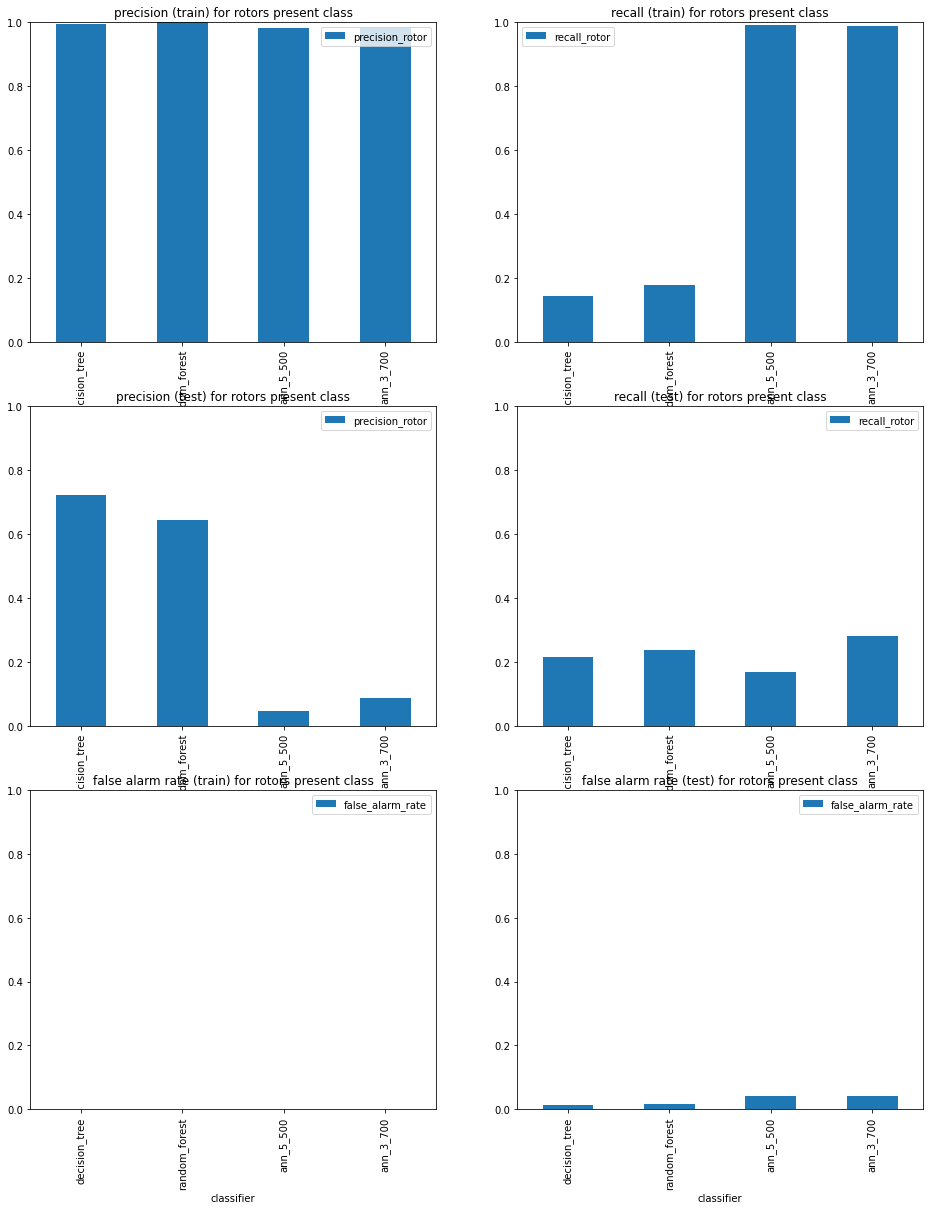

In [137]:
fig1 = matplotlib.pyplot.figure(figsize=(16,20))
ax1 = fig1.add_subplot(3,2,1,title='precision (train) for rotors present class')
train_metrics_df.plot.bar(x='classifier', y='precision_rotor', ax=ax1, ylim=[0,1])
ax1 = fig1.add_subplot(3,2,2,title='recall (train) for rotors present class')
train_metrics_df.plot.bar(x='classifier', y='recall_rotor', ax=ax1, ylim=[0,1])

ax1 = fig1.add_subplot(3,2,3,title='precision (test) for rotors present class')
test_metrics_df.plot.bar(x='classifier', y='precision_rotor', ax=ax1, ylim=[0,1])
ax1 = fig1.add_subplot(3,2,4,title='recall (test) for rotors present class')
test_metrics_df.plot.bar(x='classifier', y='recall_rotor', ax=ax1, ylim=[0,1])

ax1 = fig1.add_subplot(3,2,5,title='false alarm rate (train) for rotors present class')
train_metrics_df.plot.bar(x='classifier', y='false_alarm_rate', ax=ax1, ylim=[0,1])
ax1 = fig1.add_subplot(3,2,6,title='false alarm rate (test) for rotors present class')
test_metrics_df.plot.bar(x='classifier', y='false_alarm_rate', ax=ax1, ylim=[0,1])

In [138]:
def calc_sedi(conf_mat):
    hr1 = conf_mat[1,1] / (conf_mat[1,0] + conf_mat[1,1])
    fa1 = conf_mat[0,1] / (conf_mat[0,0] + conf_mat[0,1])
    sedi_score1 = (
        (numpy.log(fa1) - numpy.log(hr1) - numpy.log(1.0-fa1) + numpy.log(1.0-hr1) )
        / (numpy.log(fa1) + numpy.log(hr1) + numpy.log(1.0 - fa1) + numpy.log(1.0-hr1) )  )
    return sedi_score1

In [140]:
y_train_pred_raw = classifiers_dict['random_forest'].predict_proba(X_train)[:,1]
y_test_pred_raw = classifiers_dict['random_forest'].predict_proba(X_test)[:,1]

In [141]:
thresholds_list = list(numpy.arange(1e-3,0.995,5e-3))
hit_rates = []
hit_rates_test = []
false_alarm_rates = []
false_alarm_rates_test = []
sedi_list = []
sedi_list_test = []
for threshold in thresholds_list:
    y_pred_train = list(map(float, y_train_pred_raw > threshold)) 
    cm1 = sklearn.metrics.confusion_matrix(y_train, y_pred_train)
    hit_rates += [cm1[1,1] / (cm1[1,0] + cm1[1,1])]
    false_alarm_rates += [cm1[0,1] / (cm1[0,0] + cm1[0,1])]
    sedi_list += [calc_sedi(cm1)]

    y_pred_test = list(map(float, y_test_pred_raw > threshold)) 
    cm1 = sklearn.metrics.confusion_matrix(y_test, y_pred_test)
    hit_rates_test += [cm1[1,1] / (cm1[1,0] + cm1[1,1])]
    false_alarm_rates_test += [cm1[0,1] / (cm1[0,0] + cm1[0,1])]
    sedi_list_test += [calc_sedi(cm1)]

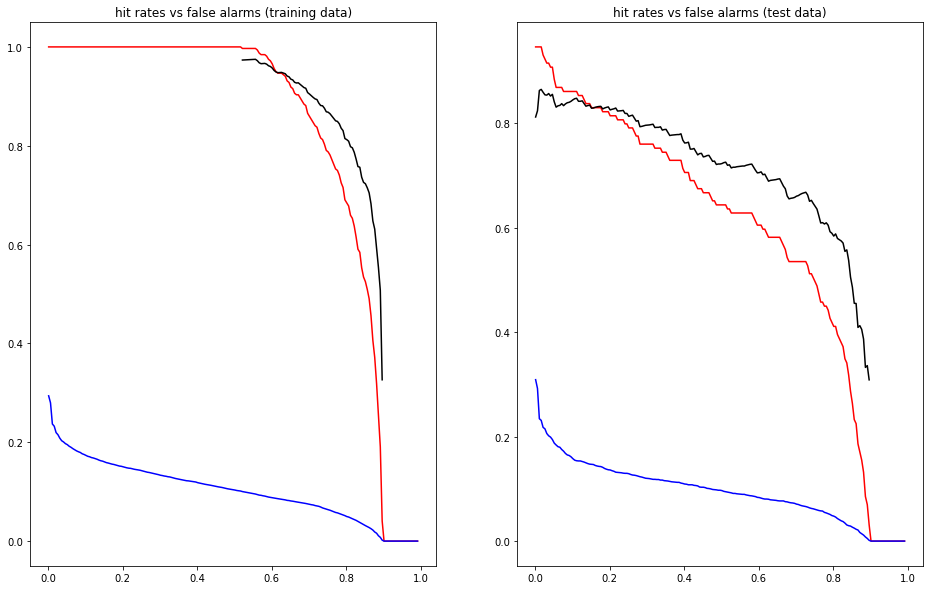

In [143]:
f1 = matplotlib.pyplot.figure(figsize=(16,10))
ax1 = f1.add_subplot(1,2,1,title='hit rates vs false alarms (training data)')
ax1.plot(thresholds_list, hit_rates,'r')
ax1.plot(thresholds_list, false_alarm_rates,'b')
ax1.plot(thresholds_list, sedi_list,'k')

ax1 = f1.add_subplot(1,2,2,title='hit rates vs false alarms (test data)')
ax1.plot(thresholds_list, hit_rates_test,'r')
ax1.plot(thresholds_list, false_alarm_rates_test,'b')
ax1.plot(thresholds_list, sedi_list_test,'k')

## Model Storage
Storing and reusing the trained classifier

discuss what elements need to be stored.

In [ ]:
# pickle a random forest object

In [ ]:
# save a random forest object using ONNX

In [ ]:
# save neural network using keras format

In [ ]:
# load NN and do inference

In [ ]:
# save neural netowrk

In [ ]:
# load in and start training (transfer learning)

## Problem 2 - Clustering weather types from ERA5

### Loading the data

In [ ]:
# load era5 pressure data

### Seperating into train/test sets

In [ ]:
# 2019-2020 train, 2021 test

### Preprocessing features

* Load MLSP data (hourly, global)
* Extract UK area from global ERA5 data
* Calculate seasonal averages
* Calculating the seasonal pressure anomaly for each hour



In [ ]:
# cut out area of interest

In [ ]:
# calculate season means

In [ ]:
# substract seasonal means

### Different ways of clustering
* flatten and k-means
* PCA and k-means
* Auto-encoder and k-means

#### Method 1 - Flatten and K-Means

#### Method 2 - PCA and K-Means

#### Method 3 - Autoencoder and Latent Space K-Means

Exploring

## Problem 3 - Radiation Emulation (Regression)

In [ ]:
# load radition dataset


In [ ]:
# prepare featureds

In [ ]:
# split into train test

In [ ]:
# set up 1D CNN architectureb

In [1]:
# do training

In [ ]:
# calculate appropriate metrics

## Examples of use
* You can see more example notebook relating to this challenge on the [Data Science CoP GitHub repositor](https://github.com/MetOffice/data_science_cop/tree/master/challenges/2021_falklands_rotors).
 


## Next steps



## Dataset Info
xx


## References
xx
